Лабораторная работа №2
Выполнил: Косов Всеволод
Группа: М8О-311Б-23

In [36]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    roc_auc_score, accuracy_score,
    precision_score, recall_score, f1_score,
    average_precision_score
)
from sklearn.base import clone

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import optuna
from scipy.special import expit

RANDOM_STATE = 42

train_df = pd.read_csv('train_c.csv')
test_df = pd.read_csv('test_c.csv')

train_df.head()

,ApplicationDate,Age,AnnualIncome,CreditScore,LoanAmount,LoanDuration,MaritalStatus,NumberOfDependents,HomeOwnershipStatus,MonthlyDebtPayments,...,JobTenure,EmploymentStatus,EducationLevel,Experience,NetWorth,BaseInterestRate,InterestRate,MonthlyLoanPayment,TotalDebtToIncomeRatio,LoanApproved
0,2010-06-26,27.0,66829.0,549.0,17290.0,60.0,Divorced,1.0,Rent,1095.0,...,4.0,Employed,Associate,4.0,35067.0,0.257790,0.251465,508.970230,0.288013,0.0
1,1996-09-23,55.0,172147.0,850.0,16110.0,36.0,Widowed,1.0,Mortgage,211.0,...,2.0,Employed,High School,33.0,27001.0,0.086110,0.093173,514.675859,0.050585,1.0
2,2015-01-19,51.0,300000.0,850.0,38436.0,36.0,Married,0.0,Mortgage,546.0,...,3.0,Employed,Bachelor,28.0,278382.0,0.108436,0.115443,1268.276385,0.072571,1.0
3,1981-05-12,25.0,34683.0,847.0,19186.0,48.0,Married,0.0,Other,153.0,...,3.0,Employed,High School,0.0,9224.0,0.100686,0.112822,498.505187,0.225415,1.0
4,1995-05-07,55.0,300000.0,850.0,30437.0,48.0,Single,2.0,Rent,562.0,...,5.0,Employed,Bachelor,31.0,4502.0,0.110437,0.089037,756.035156,0.052721,1.0


Разведочный анализ данных

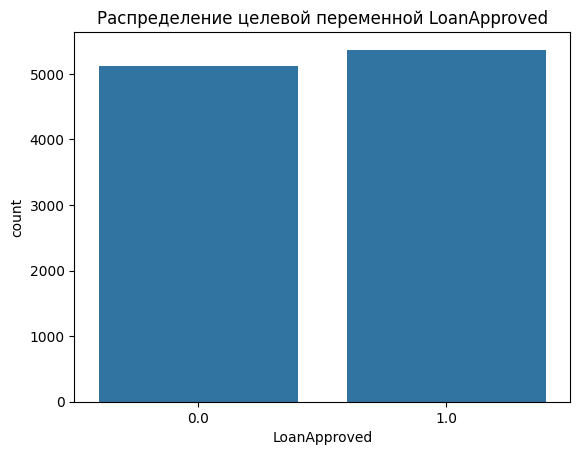

In [21]:
sns.countplot(x='LoanApproved', data=train_df)
plt.title('Распределение целевой переменной LoanApproved')
plt.show()

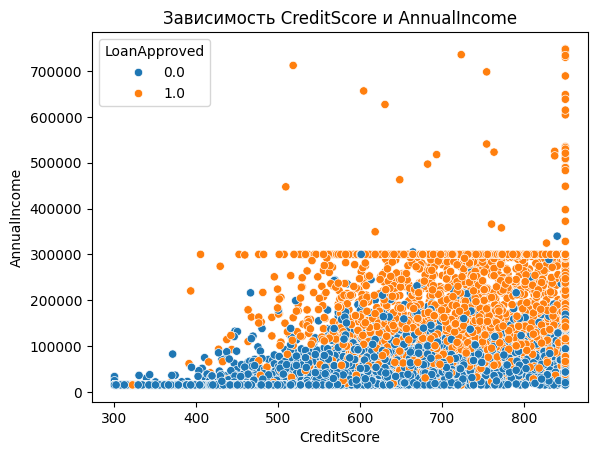

In [22]:
sns.scatterplot(
    x=train_df['CreditScore'],
    y=train_df['AnnualIncome'],
    hue=train_df['LoanApproved']
)
plt.title('Зависимость CreditScore и AnnualIncome')
plt.show()

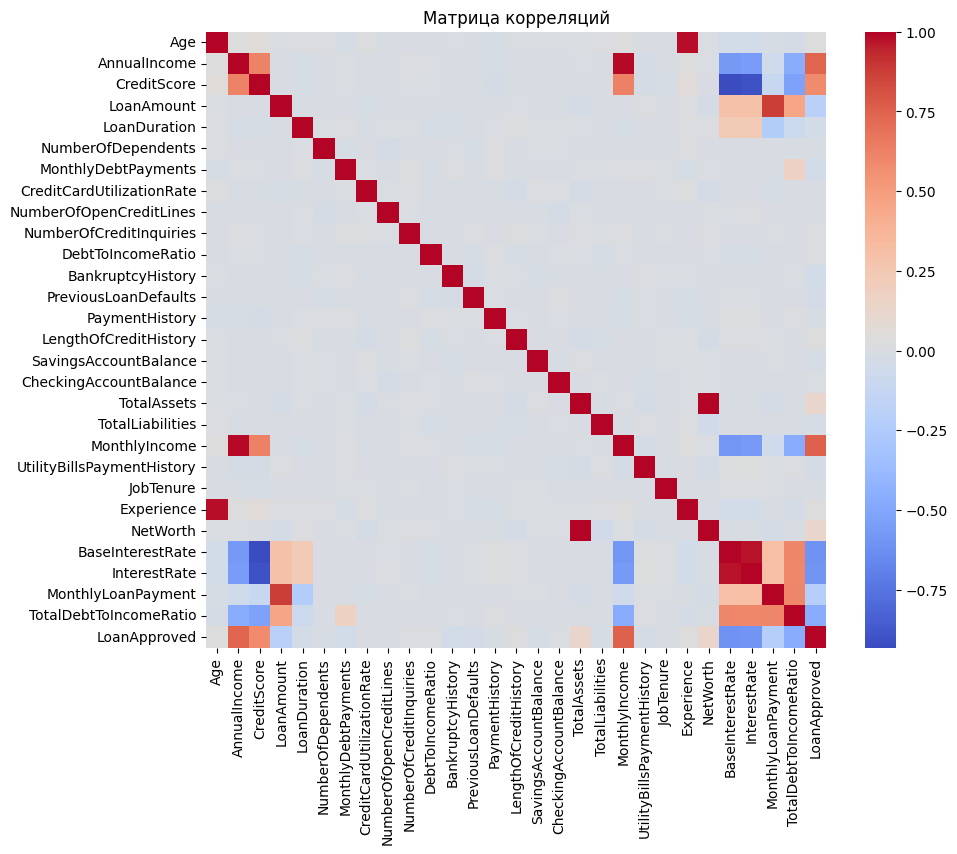

In [23]:
corr = train_df.corr(numeric_only=True)
plt.figure(figsize=(10,8))
sns.heatmap(corr, cmap='coolwarm')
plt.title('Матрица корреляций')
plt.show()

Подготовка данных

In [24]:
train_df['is_train'] = 1
test_df['is_train'] = 0
test_df['LoanApproved'] = np.nan


full = pd.concat([train_df, test_df], ignore_index=True)

num_cols = full.select_dtypes(include=np.number).columns
cat_cols = full.select_dtypes(include='object').columns

for c in num_cols:
    if c != 'LoanApproved':
        full[c].fillna(full[c].median(), inplace=True)

for c in cat_cols:
    full[c].fillna(full[c].mode()[0], inplace=True)


le = LabelEncoder()
for c in cat_cols:
    if c != 'ApplicationDate':
        full[c] = le.fit_transform(full[c].astype(str))


full.drop(columns=['ApplicationDate'], inplace=True)

train_prep = full[full.is_train == 1].drop(columns='is_train')
test_prep = full[full.is_train == 0].drop(columns=['is_train', 'LoanApproved'])

train_prep = train_prep.dropna(subset=['LoanApproved'])

X = train_prep.drop('LoanApproved', axis=1)
y = train_prep['LoanApproved'].astype(int)

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

Custom Bagging

In [25]:
class CustomBaggingClassifier:
    def __init__(self, base_estimator, n_estimators=50, random_state=42):
        self.base_estimator = base_estimator
        self.n_estimators = n_estimators
        self.random_state = random_state
        self.models = []

    def fit(self, X, y):
        rng = np.random.RandomState(self.random_state)
        self.models = []
        for _ in range(self.n_estimators):
            idx = rng.choice(len(X), len(X), replace=True)
            model = clone(self.base_estimator)
            model.fit(X.iloc[idx], y.iloc[idx])
            self.models.append(model)
        return self

    def predict_proba(self, X):
        probs = np.mean([m.predict_proba(X)[:,1] for m in self.models], axis=0)
        return np.vstack([1 - probs, probs]).T

In [26]:
custom_bag = CustomBaggingClassifier(DecisionTreeClassifier(), 50)
custom_bag.fit(X_train, y_train)


sk_bag = BaggingClassifier(DecisionTreeClassifier(), 50, random_state=RANDOM_STATE)
sk_bag.fit(X_train, y_train)


print('Custom Bagging ROC-AUC:', roc_auc_score(y_valid, custom_bag.predict_proba(X_valid)[:,1]))
print('Sklearn Bagging ROC-AUC:', roc_auc_score(y_valid, sk_bag.predict_proba(X_valid)[:,1]))

Custom Bagging ROC-AUC: 0.9784447014664804
Sklearn Bagging ROC-AUC: 0.9779859716887802


Custom Gradient Boosting

In [27]:
class CustomGradientBoostingClassifier:
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.trees = []
        self.init_score = None

    def fit(self, X, y):
        p = np.clip(y.mean(), 1e-6, 1 - 1e-6)
        self.init_score = np.log(p / (1 - p))
        F = np.full(len(y), self.init_score)
        self.trees = []

        for _ in range(self.n_estimators):
            residual = y - expit(F)
            tree = DecisionTreeRegressor(max_depth=self.max_depth)
            tree.fit(X, residual)
            F += self.learning_rate * tree.predict(X)
            self.trees.append(tree)

        return self

    def predict_proba(self, X):
        F = np.full(len(X), self.init_score)
        for tree in self.trees:
            F += self.learning_rate * tree.predict(X)
        p = expit(F)
        return np.vstack([1 - p, p]).T

In [28]:
custom_gb = CustomGradientBoostingClassifier()
custom_gb.fit(X_train, y_train)

print('Custom GB ROC-AUC:', roc_auc_score(y_valid, custom_gb.predict_proba(X_valid)[:,1]))
print('Sklearn GB ROC-AUC:', roc_auc_score(y_valid, GradientBoostingClassifier().fit(X_train, y_train).predict_proba(X_valid)[:,1]))

Custom GB ROC-AUC: 0.9750972016119647
Sklearn GB ROC-AUC: 0.980561496159218


In [29]:
models = {
    'SklearnGB': GradientBoostingClassifier(),
    'LightGBM': LGBMClassifier(verbose=-1),
    'XGBoost': XGBClassifier(eval_metric='logloss'),
    'CatBoost': CatBoostClassifier(verbose=0)
}

for name, model in models.items():
    model.fit(X_train, y_train)
print(name, roc_auc_score(y_valid, model.predict_proba(X_valid)[:,1]))

CatBoost 0.9825009820181564


Optuna

In [30]:
def objective(trial):
    model = LGBMClassifier(
        n_estimators=500,
        learning_rate=trial.suggest_float('learning_rate', 0.01, 0.2),
        num_leaves=trial.suggest_int('num_leaves', 16, 64),
        verbose=-1
    )
    model.fit(X_train, y_train)
    return roc_auc_score(y_valid, model.predict_proba(X_valid)[:,1])


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

[I 2025-12-13 23:41:55,186] A new study created in memory with name: no-name-5b4981fe-2796-4dc8-8a21-b0d236281a33
[I 2025-12-13 23:42:04,839] Trial 0 finished with value: 0.981618074953445 and parameters: {'learning_rate': 0.11312282527826444, 'num_leaves': 41}. Best is trial 0 with value: 0.981618074953445.
[I 2025-12-13 23:42:10,489] Trial 1 finished with value: 0.9823364030493482 and parameters: {'learning_rate': 0.08429508284105115, 'num_leaves': 20}. Best is trial 1 with value: 0.9823364030493482.
[I 2025-12-13 23:42:16,418] Trial 2 finished with value: 0.9824327863128491 and parameters: {'learning_rate': 0.14663527553990785, 'num_leaves': 21}. Best is trial 2 with value: 0.9824327863128491.
[I 2025-12-13 23:42:26,187] Trial 3 finished with value: 0.9816398975791434 and parameters: {'learning_rate': 0.12421850120932841, 'num_leaves': 37}. Best is trial 2 with value: 0.9824327863128491.
[I 2025-12-13 23:42:30,425] Trial 4 finished with value: 0.9818972227071694 and parameters: {'le

Метрики

In [31]:
def my_accuracy(y, yh): return (y == yh).mean()
def my_precision(y, yh): return np.sum((y==1)&(yh==1))/np.sum(yh==1)
def my_recall(y, yh): return np.sum((y==1)&(yh==1))/np.sum(y==1)
def my_f1(y, yh):
    p, r = my_precision(y, yh), my_recall(y, yh)
    return 2*p*r/(p+r)

In [32]:
best_model = LGBMClassifier(**study.best_params, n_estimators=500, verbose=-1)
best_model.fit(X_train, y_train)

proba = best_model.predict_proba(X_valid)[:,1]
pred = (proba >= 0.5).astype(int)

print('Accuracy:', my_accuracy(y_valid, pred), accuracy_score(y_valid, pred))
print('Precision:', my_precision(y_valid, pred), precision_score(y_valid, pred))
print('Recall:', my_recall(y_valid, pred), recall_score(y_valid, pred))
print('F1:', my_f1(y_valid, pred), f1_score(y_valid, pred))
print('ROC-AUC:', roc_auc_score(y_valid, proba))

Accuracy: 0.9289799809342231 0.9289799809342231
Precision: 0.9270544783010157 0.9270544783010157
Recall: 0.9348230912476723 0.9348230912476723
F1: 0.9309225776541492 0.9309225776541492
ROC-AUC: 0.9830147229981377


Custom AUC-PR / AUC-ROC

In [38]:
def my_roc_auc(y_true, y_score):
    desc_score_indices = np.argsort(y_score)[::-1]
    y_true = np.array(y_true)[desc_score_indices]
    
    tps = np.cumsum(y_true)
    fps = np.cumsum(1 - y_true)
    
    tpr = tps / tps[-1] if tps[-1] > 0 else np.zeros_like(tps)
    fpr = fps / fps[-1] if fps[-1] > 0 else np.zeros_like(fps)
    
    tpr = np.concatenate([[0], tpr])
    fpr = np.concatenate([[0], fpr])

    return np.trapz(tpr, fpr)

def my_auc_pr(y_true, y_score):
    desc_score_indices = np.argsort(y_score)[::-1]
    y_true = np.array(y_true)[desc_score_indices]
    
    tps = np.cumsum(y_true)
    fps = np.cumsum(1 - y_true)
    
    with np.errstate(divide='ignore', invalid='ignore'):
        precision = np.where((tps + fps) == 0, 0, tps / (tps + fps))
    
    relevant_mask = (y_true == 1)
    
    if not np.any(relevant_mask): return 0.0
    
    prec_at_k = precision[relevant_mask]
    
    return np.sum(prec_at_k) / np.sum(y_true)

my_auc = my_roc_auc(y_valid, proba)
sk_auc = roc_auc_score(y_valid, proba)

my_pr = my_auc_pr(y_valid, proba)
sk_pr = average_precision_score(y_valid, proba)

print(f"Custom ROC-AUC: {my_auc}")
print(f"Sklearn ROC-AUC: {sk_auc}")
print(f"ROC-AUC Difference: {abs(my_auc - sk_auc)}")

print(f"Custom AUC-PR (AP): {my_pr}")
print(f"Sklearn AUC-PR (AP): {sk_pr}")
print(f"AUC-PR (AP) Difference: {abs(my_pr - sk_pr)}")

Custom ROC-AUC: 0.9830147229981377
Sklearn ROC-AUC: 0.9830147229981377
ROC-AUC Difference: 0.0
Custom AUC-PR (AP): 0.984878187843174
Sklearn AUC-PR (AP): 0.9848783204119409
AUC-PR (AP) Difference: 1.325687668529696e-07


Сабмит

In [34]:
best_model.fit(X, y)
test_pred = best_model.predict_proba(test_prep)[:,1]

submission = pd.DataFrame({
    'ID': range(len(test_pred)),
    'LoanApproved': test_pred
})

submission.to_csv('submission.csv', index=False)